In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
import numpy as np
from bb_opt.src.utils import get_path
from bb_opt.src.hsic import dimwise_mixrq_kernels
from bb_opt.src.bayesian_opt import (
    optimize,
    get_model_uniform,
    get_model_nn,
    get_model_bnn,
    acquire_batch_uniform,
    acquire_batch_nn_greedy,
    acquire_batch_bnn_greedy,
    acquire_batch_pdts,
    acquire_batch_hsic_mean_std,
    acquire_batch_hsic_pdts,
    acquire_batch_mves,
    acquire_batch_es,
    acquire_batch_pi,
    train_model_uniform,
    train_model_nn,
    train_model_bnn,
    partial_train_model_bnn,
)

In [2]:
import seaborn as sns
%matplotlib inline

def jointplot(predicted, true, title: str=""):
    if isinstance(predicted, torch.Tensor):
        predicted = predicted.detach().cpu().numpy()

    if isinstance(true, torch.Tensor):
        true = true.detach().cpu().numpy()
        
    ax = sns.jointplot(predicted, true, s=3, alpha=0.5)
    ax.set_axis_labels('Predicted', 'True')
    ax.ax_marg_x.set_title(title)
    return ax

In [3]:
models = {
    "uniform": get_model_uniform,
    "nn": get_model_nn,
    "bnn": get_model_bnn,
    "pdts": get_model_bnn,
    "hsic_ms": get_model_bnn,
    "hsic_pdts": get_model_bnn,
    "mves": get_model_bnn,
    "es": get_model_bnn,
    "pi": get_model_bnn,
}

acquisition_functions = {
    "uniform": acquire_batch_uniform,
    "nn": acquire_batch_nn_greedy,
    "bnn": acquire_batch_bnn_greedy,
    "pdts": acquire_batch_pdts,
    "hsic_ms": acquire_batch_hsic_mean_std,
    "hsic_pdts": acquire_batch_hsic_pdts,
    "mves": acquire_batch_mves,
    "es": acquire_batch_es,
    "pi": acquire_batch_pi,
}

train_functions = {
    "uniform": train_model_uniform,
    "nn": train_model_nn,
    "bnn": train_model_bnn,
    "pdts": train_model_bnn,
    "hsic_ms": train_model_bnn,
    "hsic_pdts": train_model_bnn,
    "mves": train_model_bnn,
    "es": train_model_bnn,
    "pi": train_model_bnn,
}

partial_train_functions = {
    "uniform": train_model_uniform,
    "nn": None,
    "bnn": partial_train_model_bnn,
    "pdts": partial_train_model_bnn,
    "hsic_ms": partial_train_model_bnn,
    "hsic_pdts": partial_train_model_bnn,
    "mves": partial_train_model_bnn,
    "es": partial_train_model_bnn,
    "pi": partial_train_model_bnn,
}

In [13]:
model_key = "mves"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
project = "dna_binding"
dataset = "crx_ref_r1"
batch_size = 1
n_epochs = -1
n_batches = 100
retrain_every = 1000000
partial_steps = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

root = "/cluster/nhunt/github/bb_opt/"
data_dir = get_path(root, "data", project, dataset)
inputs = np.load(get_path(data_dir, "inputs.npy"))
labels = np.load(get_path(data_dir, "labels.npy"))

top_k_percent = 1

acquisition_args = {}
acquisition_args["kernel"] = dimwise_mixrq_kernels # dimwise_mixrbf_kernels

# model, svi = optimize(
#     models[model_key],
#     acquisition_functions[model_key],
#     train_functions[model_key],
#     inputs,
#     labels,
#     top_k_percent,
#     batch_size,
#     n_epochs,
#     device,
#     verbose=True,
#     exp=None,
#     acquisition_args=acquisition_args,
#     n_batches=n_batches,
#     retrain_every=retrain_every,
#     partial_train_steps=partial_steps,
#     partial_train_func=partial_train_functions[model_key],
# )

In [14]:
import pyro

bnn_model, guide = get_model_bnn()
optimizer = pyro.optim.Adam({})

In [15]:
model_name = "crx_prediction"
pyro.get_param_store().load(f"{model_name}.params")
optimizer.load(f"{model_name}.opt")

In [16]:
inputs = torch.tensor(inputs, dtype=torch.float32, device=device)
labels = torch.tensor(labels, dtype=torch.float32, device=device)

In [17]:
n_preds = 1000

with torch.no_grad():
    preds = torch.stack([guide()(inputs).squeeze() for _ in range(n_preds)])

max_idx = preds.argmax(dim=1)
max_dist = inputs[max_idx]

max_value_dist = labels[max_idx]

ValueError: param g_0.weight_location init tensor shape does not match existing value: torch.Size([100, 512]) vs torch.Size([100, 32])

bnn_antibody.ipynb	crx_prediction.opt	    neural_process.ipynb
bnn_antibody.md		crx_prediction.params	    np_kaspar.ipynb
bnn_pdts.ipynb		CRX_REF_R1_8mers.txt	    np_kaspar.md
bnn_pdts.md		dna_binding.ipynb	    tmp.png
bnn_toy_funcs.ipynb	dosage_response_data.ipynb  Untitled Folder
comet_charts.ipynb	hsic_testing.ipynb	    Untitled.ipynb
corrs.npz		hsic_timing.ipynb	    vae_example.ipynb
crx_prediction1.opt	mi_testing.ipynb
crx_prediction1.params	mnf.ipynb


In [60]:
from bb_opt.src.hsic import precompute_batch_hsic_stats, compute_point_hsics, dimwise_mixrbf_kernels

# kernel = dimwise_mixrq_kernels
kernel = dimwise_mixrbf_kernels
n_points_parallel = 50
acquirable_idx = list(range(len(inputs)))

batch_stats = precompute_batch_hsic_stats(max_dist.unsqueeze(1), kernel=kernel)

all_hsics = []
all_idx = list(acquirable_idx)

for next_points in torch.tensor(all_idx).split(n_points_parallel):
    hsics = compute_point_hsics(preds, next_points, *batch_stats, kernel)
    all_hsics.append(hsics.cpu().numpy())

all_hsics = np.concatenate(all_hsics)

[autoreload of bb_opt.src.utils failed: Traceback (most recent call last):
  File "/cluster/nhunt/anaconda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/cluster/nhunt/anaconda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/cluster/nhunt/anaconda/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/cluster/nhunt/anaconda/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/cluster/nhunt/github/bb_opt/src/utils.py", line 9, in <module>
    import sascorer
ModuleNotFoundError: No module named 'sascorer'
]


AssertionError: 

In [50]:
import matplotlib.pyplot as plt

Text(0,0.5,'Target')

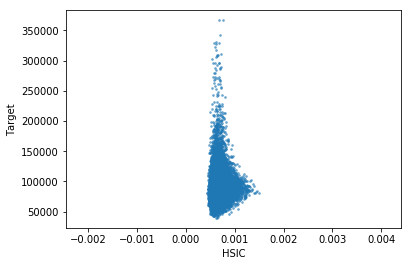

In [55]:
plt.scatter(all_hsics, labels.cpu().numpy(), s=3, alpha=0.5)
plt.xlabel("HSIC")
plt.ylabel("Target")

Text(336.971,0.5,'Target')

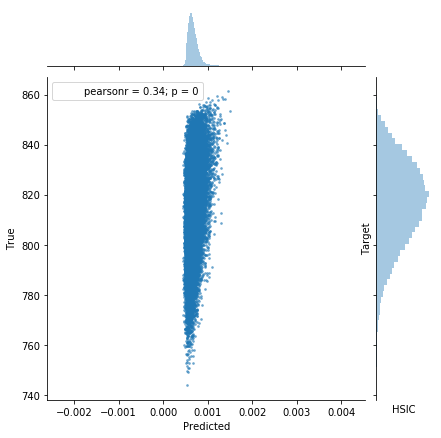

In [59]:
jointplot(all_hsics, preds.mean(dim=0))
plt.xlabel("HSIC")
plt.ylabel("Target")

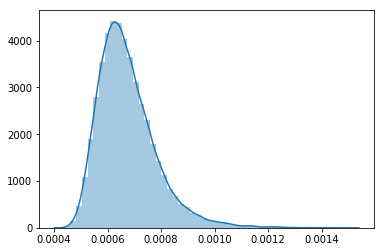

In [45]:
sns.distplot(all_hsics)

In [46]:
all_hsics.std()

0.0001085429

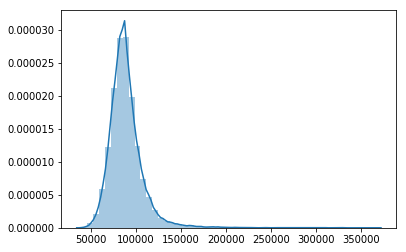

In [37]:
sns.distplot(labels)

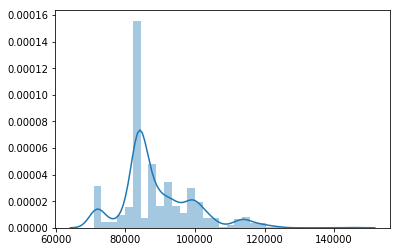

In [34]:
sns.distplot(max_value_dist)

In [31]:
max_dist

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [32]:
mode_count = (max_idx == max_idx.mode()[0]).sum().item()
mode_count / len(max_dist)

0.262

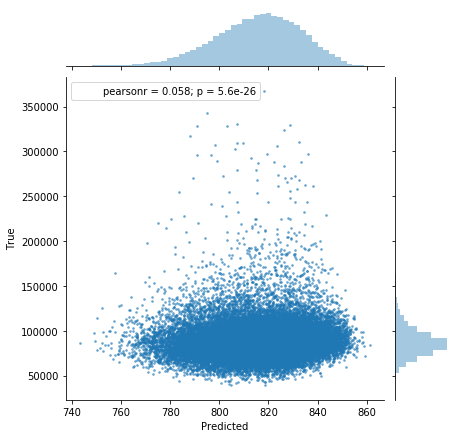

In [30]:
jointplot(preds.mean(dim=0), labels)